<a href="https://colab.research.google.com/github/ArgonautAli/doodle-lab/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Authenticate google account to access data

In [ ]:
from google.colab import auth
auth.authenticate_user()

Access data


In [ ]:
!pip install google-cloud-storage

Installing specific tensorflow versions

In [ ]:
!pip install tensorflow
!pip install tensorflowjs

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 62.1 MB/s eta 0:00:0

Importing dependencies

In [ ]:
import io
import json
import keras
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflowjs as tfjs
import matplotlib.pyplot as plt

from PIL import Image
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from google.colab import files
from google.cloud import storage
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split



> Checking installed versions



In [ ]:
!python --version
print("tf version",tf.__version__)
print("tfjs version",tfjs.__version__)

Python 3.10.12
tf version 2.16.2
tfjs version 4.20.0


Collecting sample categories

npy_files: ['full/numpy_bitmap/ambulance.npy', 'full/numpy_bitmap/cat.npy', 'full/numpy_bitmap/dog.npy', 'full/numpy_bitmap/house.npy', 'full/numpy_bitmap/tree.npy']


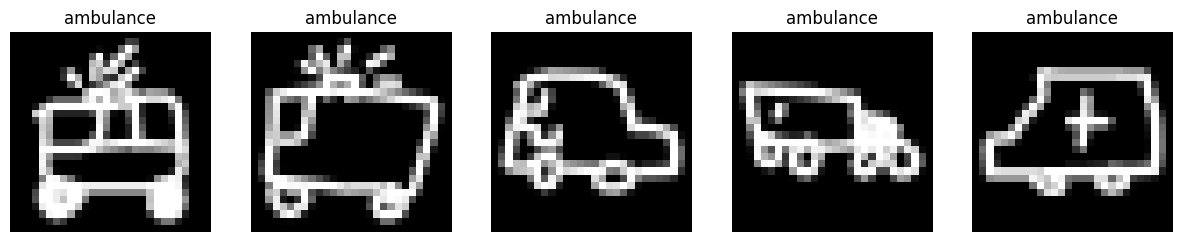

ambulance: shape (148004, 784), dtype uint8, min 0, max 255


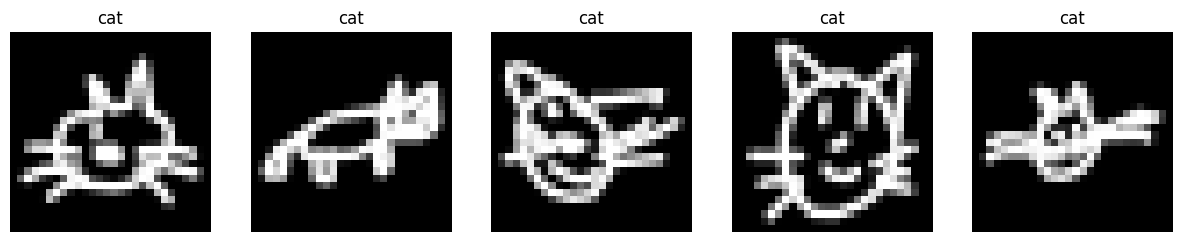

cat: shape (123202, 784), dtype uint8, min 0, max 255


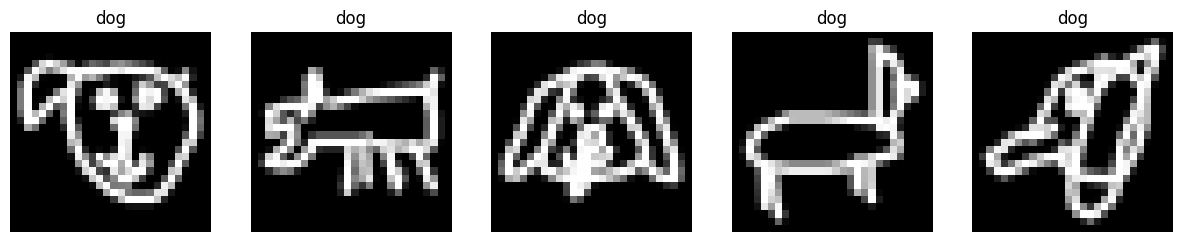

dog: shape (152159, 784), dtype uint8, min 0, max 255


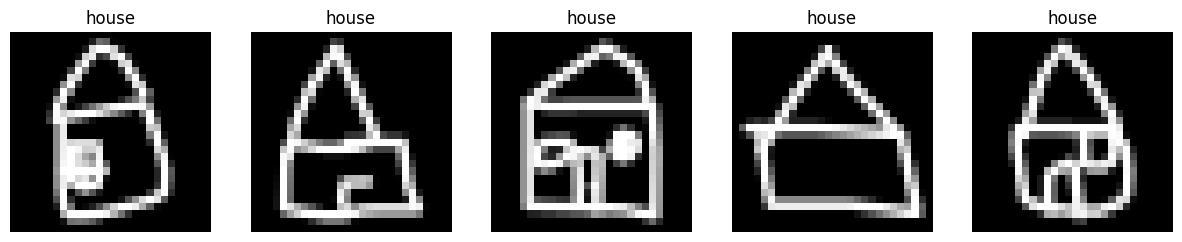

house: shape (135420, 784), dtype uint8, min 0, max 255


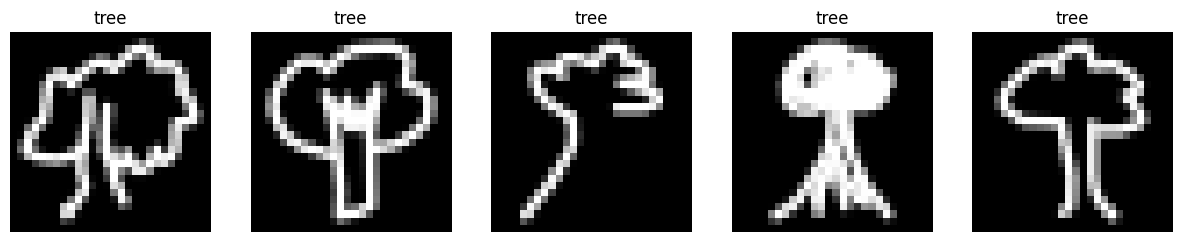

tree: shape (144721, 784), dtype uint8, min 0, max 255


In [ ]:
def download_npy_file(bucket_name, file_name, sample_categories):
    if any(category == file_name.split('/')[-1].replace('.npy', '') for category in sample_categories):
        client = storage.Client()
        bucket = client.get_bucket(bucket_name)
        blob = bucket.blob(file_name)
        local_file_name = f"/tmp/{file_name.split('/')[-1]}"
        blob.download_to_filename(local_file_name)
        return local_file_name
    else:
        return None

def list_npy_files(bucket_name, prefix, sample_categories):
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blobs = bucket.list_blobs(prefix=prefix)

    # Filter blobs by exact sample categories
    npy_files = [blob.name for blob in blobs
                 if blob.name.endswith('.npy') and
                 any(blob.name.split('/')[-1].replace('.npy', '') == category for category in sample_categories)]
    return npy_files

bucket_name = "quickdraw_dataset"
prefix = "full/numpy_bitmap/"

# Sample a few categories
sample_categories = ['ambulance', 'cat', 'dog', 'house', 'tree']

npy_files = list_npy_files(bucket_name, prefix, sample_categories)
print(f"npy_files: {npy_files}")


for category in sample_categories:
    file_name = f"{prefix}{category}.npy"
    local_file = download_npy_file(bucket_name, file_name, sample_categories)
    data = np.load(local_file)

    # Display a few samples
    plt.figure(figsize=(15, 3))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(data[i].reshape(28, 28), cmap='gray')
        plt.title(category)
        plt.axis('off')
    plt.show()

    print(f"{category}: shape {data.shape}, dtype {data.dtype}, min {data.min()}, max {data.max()}")

Building a simple model!!!

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.4933 - loss: 1.3248 - val_accuracy: 0.7730 - val_loss: 0.6545
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8070 - loss: 0.5426 - val_accuracy: 0.8150 - val_loss: 0.5159
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8410 - loss: 0.4419 - val_accuracy: 0.8110 - val_loss: 0.5136
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8806 - loss: 0.3356 - val_accuracy: 0.8430 - val_loss: 0.4590
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.8911 - loss: 0.3000 - val_accuracy: 0.8590 - val_loss: 0.4250
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.9191 - loss: 0.2388 - val_accuracy: 0.8640 - val_loss: 0.3968
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.9293 - loss: 0.1916 - val_accuracy: 0.8590 - val_loss: 0.4055
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9271 - loss: 0.1852 - val_accuracy: 0.868

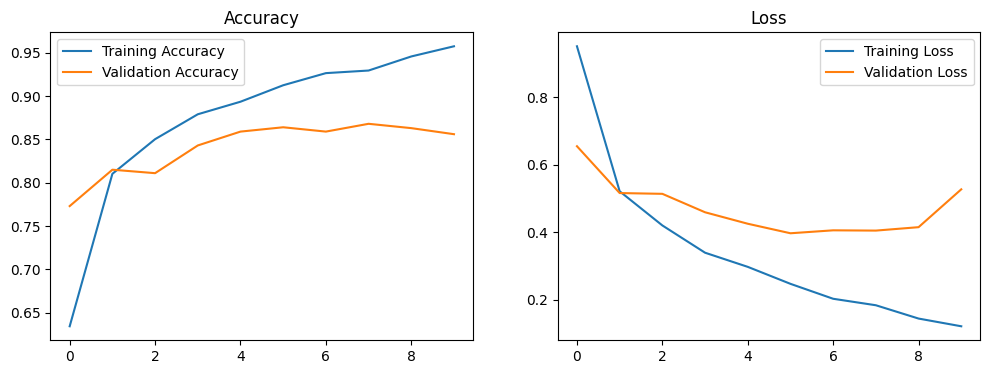

In [ ]:
X = []
y = []

for i, category in enumerate(sample_categories):
    file_name = f"{prefix}{category}.npy"
    local_file = download_npy_file(bucket_name, file_name, sample_categories)
    data = np.load(local_file)
    X.append(data[:1000])  # Let's use only 1000 samples per category for quick testing
    y.append(np.full(1000, i))

X = np.concatenate(X)
y = np.concatenate(y)

# Normalize the data
X = X.astype('float32') / 255.0

# Reshape X to (samples, 28, 28, 1)
X = X.reshape(-1, 28, 28, 1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')  # Adjust the number of units to match your number of categories
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=10,
                    batch_size=32,
                    verbose=1)

model.save('doodle_classifier_full_data.keras')
print("Model saved as 'doodle_classifier_full_data.keras'")

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()


Testing on sample data

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


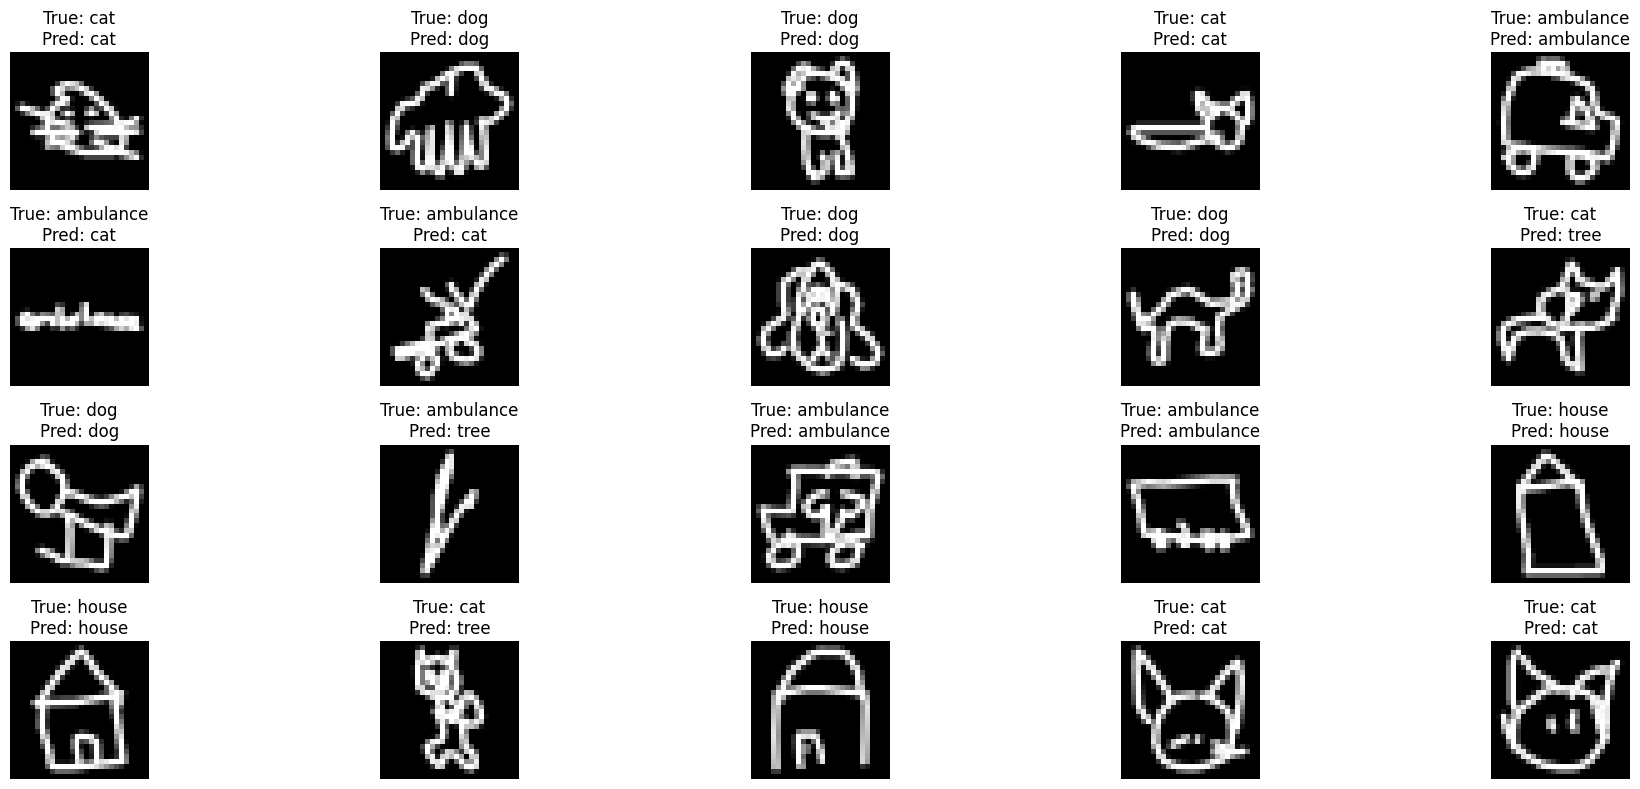

In [ ]:
# Test on some samples
test_samples = X_test[:20]
predictions = model.predict(test_samples)
predicted_classes = np.argmax(predictions, axis=1)

plt.figure(figsize=(20, 8))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(test_samples[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {sample_categories[y_test[i]]}\nPred: {sample_categories[predicted_classes[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

Upload files to test

npy_files: ['full/numpy_bitmap/ambulance.npy', 'full/numpy_bitmap/cat.npy', 'full/numpy_bitmap/dog.npy', 'full/numpy_bitmap/house.npy', 'full/numpy_bitmap/tree.npy']
Please upload a doodle image.


Saving images (2).jpeg to images (2).jpeg


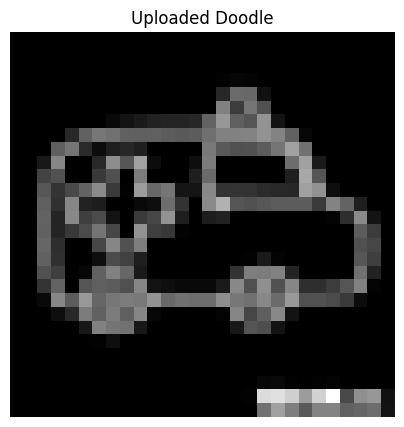

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step

The model predicts this is a: dog

Top 5 predictions:
dog: 36.53%
cat: 23.36%
tree: 12.56%
house: 9.70%
ambulance: 8.29%


In [ ]:
print("npy_files:",npy_files)

def process_image(uploaded_file):
    from PIL import Image, ImageOps
    import numpy as np
    import io

    # Read the file
    image = Image.open(io.BytesIO(uploaded_file)).convert('L')  # Convert to grayscale

    inverted_image = ImageOps.invert(image)

    # Resize the image to 28x28 (the input size for the model)
    resized_image = inverted_image.resize((28, 28))

    # Convert to numpy array and normalize
    input_data = np.array(resized_image).astype('float32') / 255.0

    # Reshape to match the model's input shape
    input_data = input_data.reshape(1, 28, 28, 1)  # Add batch dimension

    return input_data


def predict_doodle(model, input_data, categories):
    # Make a prediction
    prediction = model.predict(input_data)

    # Get the predicted class
    predicted_class = np.argmax(prediction)
    predicted_category = categories[predicted_class]

    # Get top 5 predictions
    top_5 = np.argsort(prediction[0])[-5:][::-1]
    top_5_predictions = [(categories[i], prediction[0][i]*100) for i in top_5]

    return predicted_category, top_5_predictions

# Load the model
model = tf.keras.models.load_model('doodle_classifier_full_data.keras')

# Load categories (assuming you have this list from before)
# If not, you'll need to recreate it
categories = [file.split('/')[-1].split('.')[0] for file in npy_files]

print("Please upload a doodle image.")
uploaded = files.upload()

if uploaded:
    for filename, file_content in uploaded.items():
        # Process the image
        input_data = process_image(file_content)

        # Display the image
        plt.figure(figsize=(5,5))
        plt.imshow(input_data.reshape(28, 28), cmap='gray')
        plt.title("Uploaded Doodle")
        plt.axis('off')
        plt.show()

        # Make prediction
        predicted_category, top_5_predictions = predict_doodle(model, input_data, categories)

        # Print results
        print(f"\nThe model predicts this is a: {predicted_category}")
        print("\nTop 5 predictions:")
        for category, probability in top_5_predictions:
            print(f"{category}: {probability:.2f}%")
else:
    print("No file was uploaded. Please run the cell again and upload an image.")


Diagnosing if there's a problem in data

In [ ]:
for category in test_categories:
    file_name = f"{prefix}{category}.npy"
    local_file = download_npy_file(bucket_name, file_name, sample_categories)
    data = np.load(local_file)

    # Preprocess
    data = data.astype('float32') / 255.0
    data = data.reshape((-1, 28, 28, 1))
    # Predict
    predictions = model.predict(data[:100])  # Test on first 100 samples
    predicted_classes = np.argmax(predictions, axis=1)

    # Count predictions
    unique, counts = np.unique(predicted_classes, return_counts=True)
    pred_dict = dict(zip(unique, counts))

    print(f"\nPredictions for {category}:")
    for pred_class, count in pred_dict.items():
        print(f"{categories[pred_class]}: {count}")

NameError: name 'test_categories' is not defined

Re-examining the data

In [ ]:
for category in categories:
    file_name = f"{prefix}{category}.npy"
    local_file = download_npy_file(bucket_name, file_name, sample_categories)
    data = np.load(local_file)
    print(f"{category}: {len(data)} samples")

# Getting model summary

In [ ]:
loaded_model = tf.keras.models.load_model('doodle_classifier_full_data.keras')
loaded_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 279,968 (1.07 MB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 186,646 (729.09 KB)

# Plotting confusion matrix

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


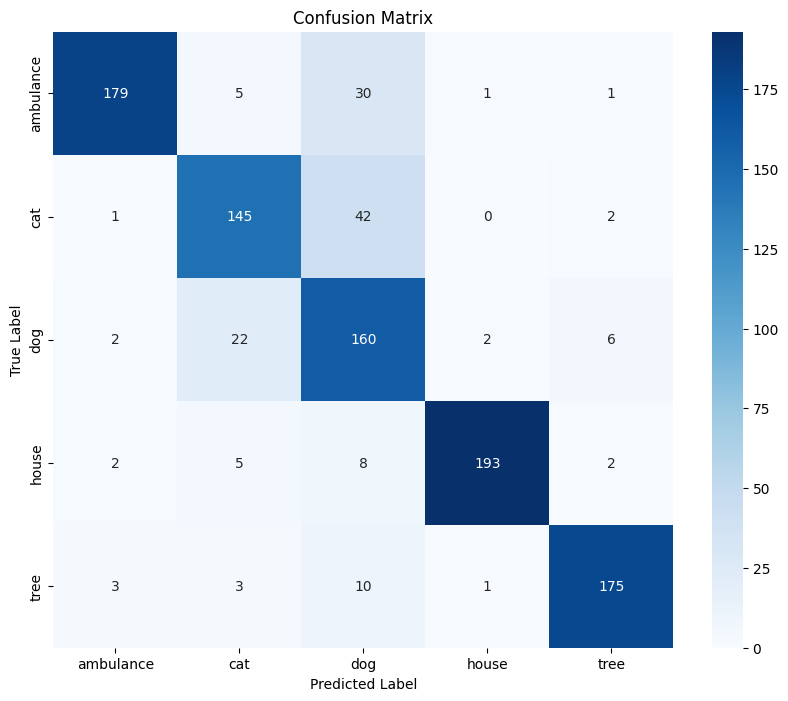

In [ ]:
# Get predictions on the entire test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sample_categories,
            yticklabels=sample_categories)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Converting model to tfjs

In [ ]:
# Load the model in native Keras format
keras_model = tf.keras.models.load_model('doodle_classifier_full_data.keras')

# Example input shape (adjust according to your model's input requirements)
input_shape = (28, 28, 1)

# Ensure the input shape is set correctly
keras_model.build((None,) + input_shape)
keras_model.summary()
# Convert the Keras model to TensorFlow.js format
tfjs.converters.save_keras_model(keras_model, 'tfjs_model')


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 279,968 (1.07 MB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 186,646 (729.09 KB)

failed to lookup keras version from the file,
    this is likely a weight only file


# Zipping the converted model

In [ ]:
# Download the TensorFlow.js model directory as a zip file
!zip -r tfjs_model.zip tfjs_model

updating: tfjs_model/ (stored 0%)
updating: tfjs_model/group1-shard1of1.bin (deflated 8%)
updating: tfjs_model/model.json (deflated 84%)


# Downloading the zipped model

In [ ]:
# Download the model file
files.download('tfjs_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>